In [31]:
import numba
import tensorflow as tf
import pandas as pd
import numpy as np
import random
import gc  # garbage collector

from fastcore.basics import *
from fastcore.parallel import *
from numba import jit, njit, vectorize, cuda, uint32, f8, uint8

from sklearn.model_selection import train_test_split
from sklearn import metrics  # for accuracy calculation
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import roc_auc_score, accuracy_score
from functools import partial
from os import cpu_count
import matplotlib.pyplot as plt
import seaborn as sns

import math
from pylab import imshow, show
from timeit import default_timer as timer

from dask import dataframe as dd
from dask.distributed import Client

In [32]:
path_DdoS_DNS = "C:\\CIC-DDOS-2019\\AfterDataCleaning\\DrDoS_DNS.csv"
path_DdoS_MSSQL = "C:\\CIC-DDOS-2019\\AfterDataCleaning\\DrDoS_MSSQL.csv"
path_DdoS_LDAP = "C:\\CIC-DDOS-2019\\AfterDataCleaning\\DrDoS_LDAP.csv"
path_DdoS_NTP = "C:\\CIC-DDOS-2019\\AfterDataCleaning\\DrDoS_NTP.csv"
path_DdoS_NetBIOS = "C:\\CIC-DDOS-2019\\AfterDataCleaning\\DrDoS_NetBIOS.csv"
path_DdoS_SNMP = "C:\\CIC-DDOS-2019\\AfterDataCleaning\\DrDoS_SNMP.csv"
path_DdoS_SSDP = "C:\\CIC-DDOS-2019\\AfterDataCleaning\\DrDoS_SSDP.csv"
path_DdoS_UDP = "C:\\CIC-DDOS-2019\\AfterDataCleaning\\DrDoS_UDP.csv"
path_Syn = "C:\\CIC-DDOS-2019\\AfterDataCleaning\\Syn.csv"
path_TFTP = "C:\\CIC-DDOS-2019\\AfterDataCleaning\\TFTP.csv"
path_UDPLag = "C:\\CIC-DDOS-2019\\AfterDataCleaning\\UDPLag.csv"

In [33]:
def readHugeCsvFileAsDataFrame(file_path):
    # start = timer()
    dtypes = {'SimillarHTTP': 'object',
              'Timestamp': 'object',
              'Source IP': 'str',
              'Destination IP': 'str',
              'Flow ID': 'object',
              'Label': 'object',
              }
    for feature in [f'f_{i}' for i in range(82)]:
        dtypes[feature] = "float32"

    dask_df = dd.read_csv(file_path, low_memory=False, blocksize=50000, dtype=dtypes)  # 50MB chunk-size
    return dask_df.compute()

In [34]:
%%time
scheduler = Client()
worker = scheduler.submit(readHugeCsvFileAsDataFrame, path_UDPLag)
workingDataFrame = worker.result()
workingDataFrame

C:\Users\Malware\anaconda3\envs\ml_env\lib\site-packages\distributed\node.py:161: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 12809 instead
  f"Port {expected} is already in use.\n"


Wall time: 22.7 s


,Unnamed: 0,Protocol,Flow Duration,Total Fwd Packets,Total Backward Packets,Fwd Packets Length Total,Bwd Packets Length Total,Fwd Packet Length Max,Fwd Packet Length Min,Fwd Packet Length Mean,...,Fwd Seg Size Min,Active Mean,Active Std,Active Max,Active Min,Idle Mean,Idle Std,Idle Max,Idle Min,Label
0,0,17,1,2,0,766.0,0.0,383.0,383.0,383.0,...,-1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,UDP-lag
1,1,17,1,2,0,778.0,0.0,389.0,389.0,389.0,...,-1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,UDP-lag
2,2,17,2,2,0,750.0,0.0,375.0,375.0,375.0,...,-1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,UDP-lag
3,3,17,2,2,0,738.0,0.0,369.0,369.0,369.0,...,-1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,UDP-lag
4,4,17,1,2,0,750.0,0.0,375.0,375.0,375.0,...,-1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,UDP-lag
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
87,92931,6,175,2,0,0.0,0.0,0.0,0.0,0.0,...,20,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,UDP-lag
88,92932,6,2951,1,1,0.0,0.0,0.0,0.0,0.0,...,32,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,WebDDoS
89,92933,6,95,1,2,0.0,0.0,0.0,0.0,0.0,...,32,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,WebDDoS
90,92934,6,114,2,2,0.0,0.0,0.0,0.0,0.0,...,20,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,UDP-lag


<class 'pandas.core.series.Series'>
Number of UDPLag :  88980
Number of Benign:  3542
Number of WebDDoS :  414


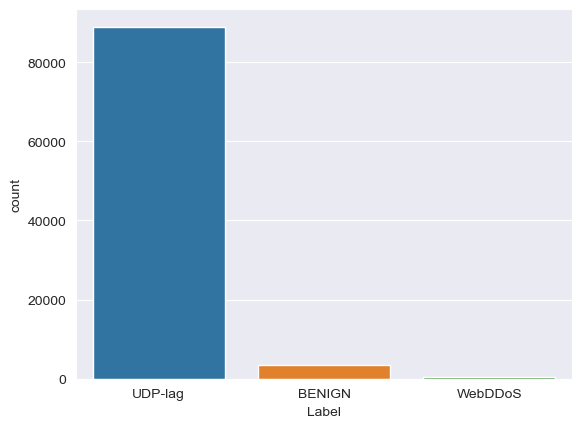

In [35]:
 #Target variable
y = workingDataFrame.Label
print(type(y))
# generating heatmap
ax = sns.countplot(x=y, label="Count")
U, B, W = y.value_counts()
print('Number of UDPLag : ', U)
print('Number of Benign: ', B)
print('Number of WebDDoS : ', W)

Variance Threshold can work only upon numerical data

In [36]:
from sklearn.preprocessing import OrdinalEncoder

ord_enc = OrdinalEncoder()
workingDataFrame['Label'] = ord_enc.fit_transform(workingDataFrame[['Label']])
workingDataFrame['Label'] = pd.to_numeric(workingDataFrame['Label'], downcast='float')

Correlation Matrix with Heatmap

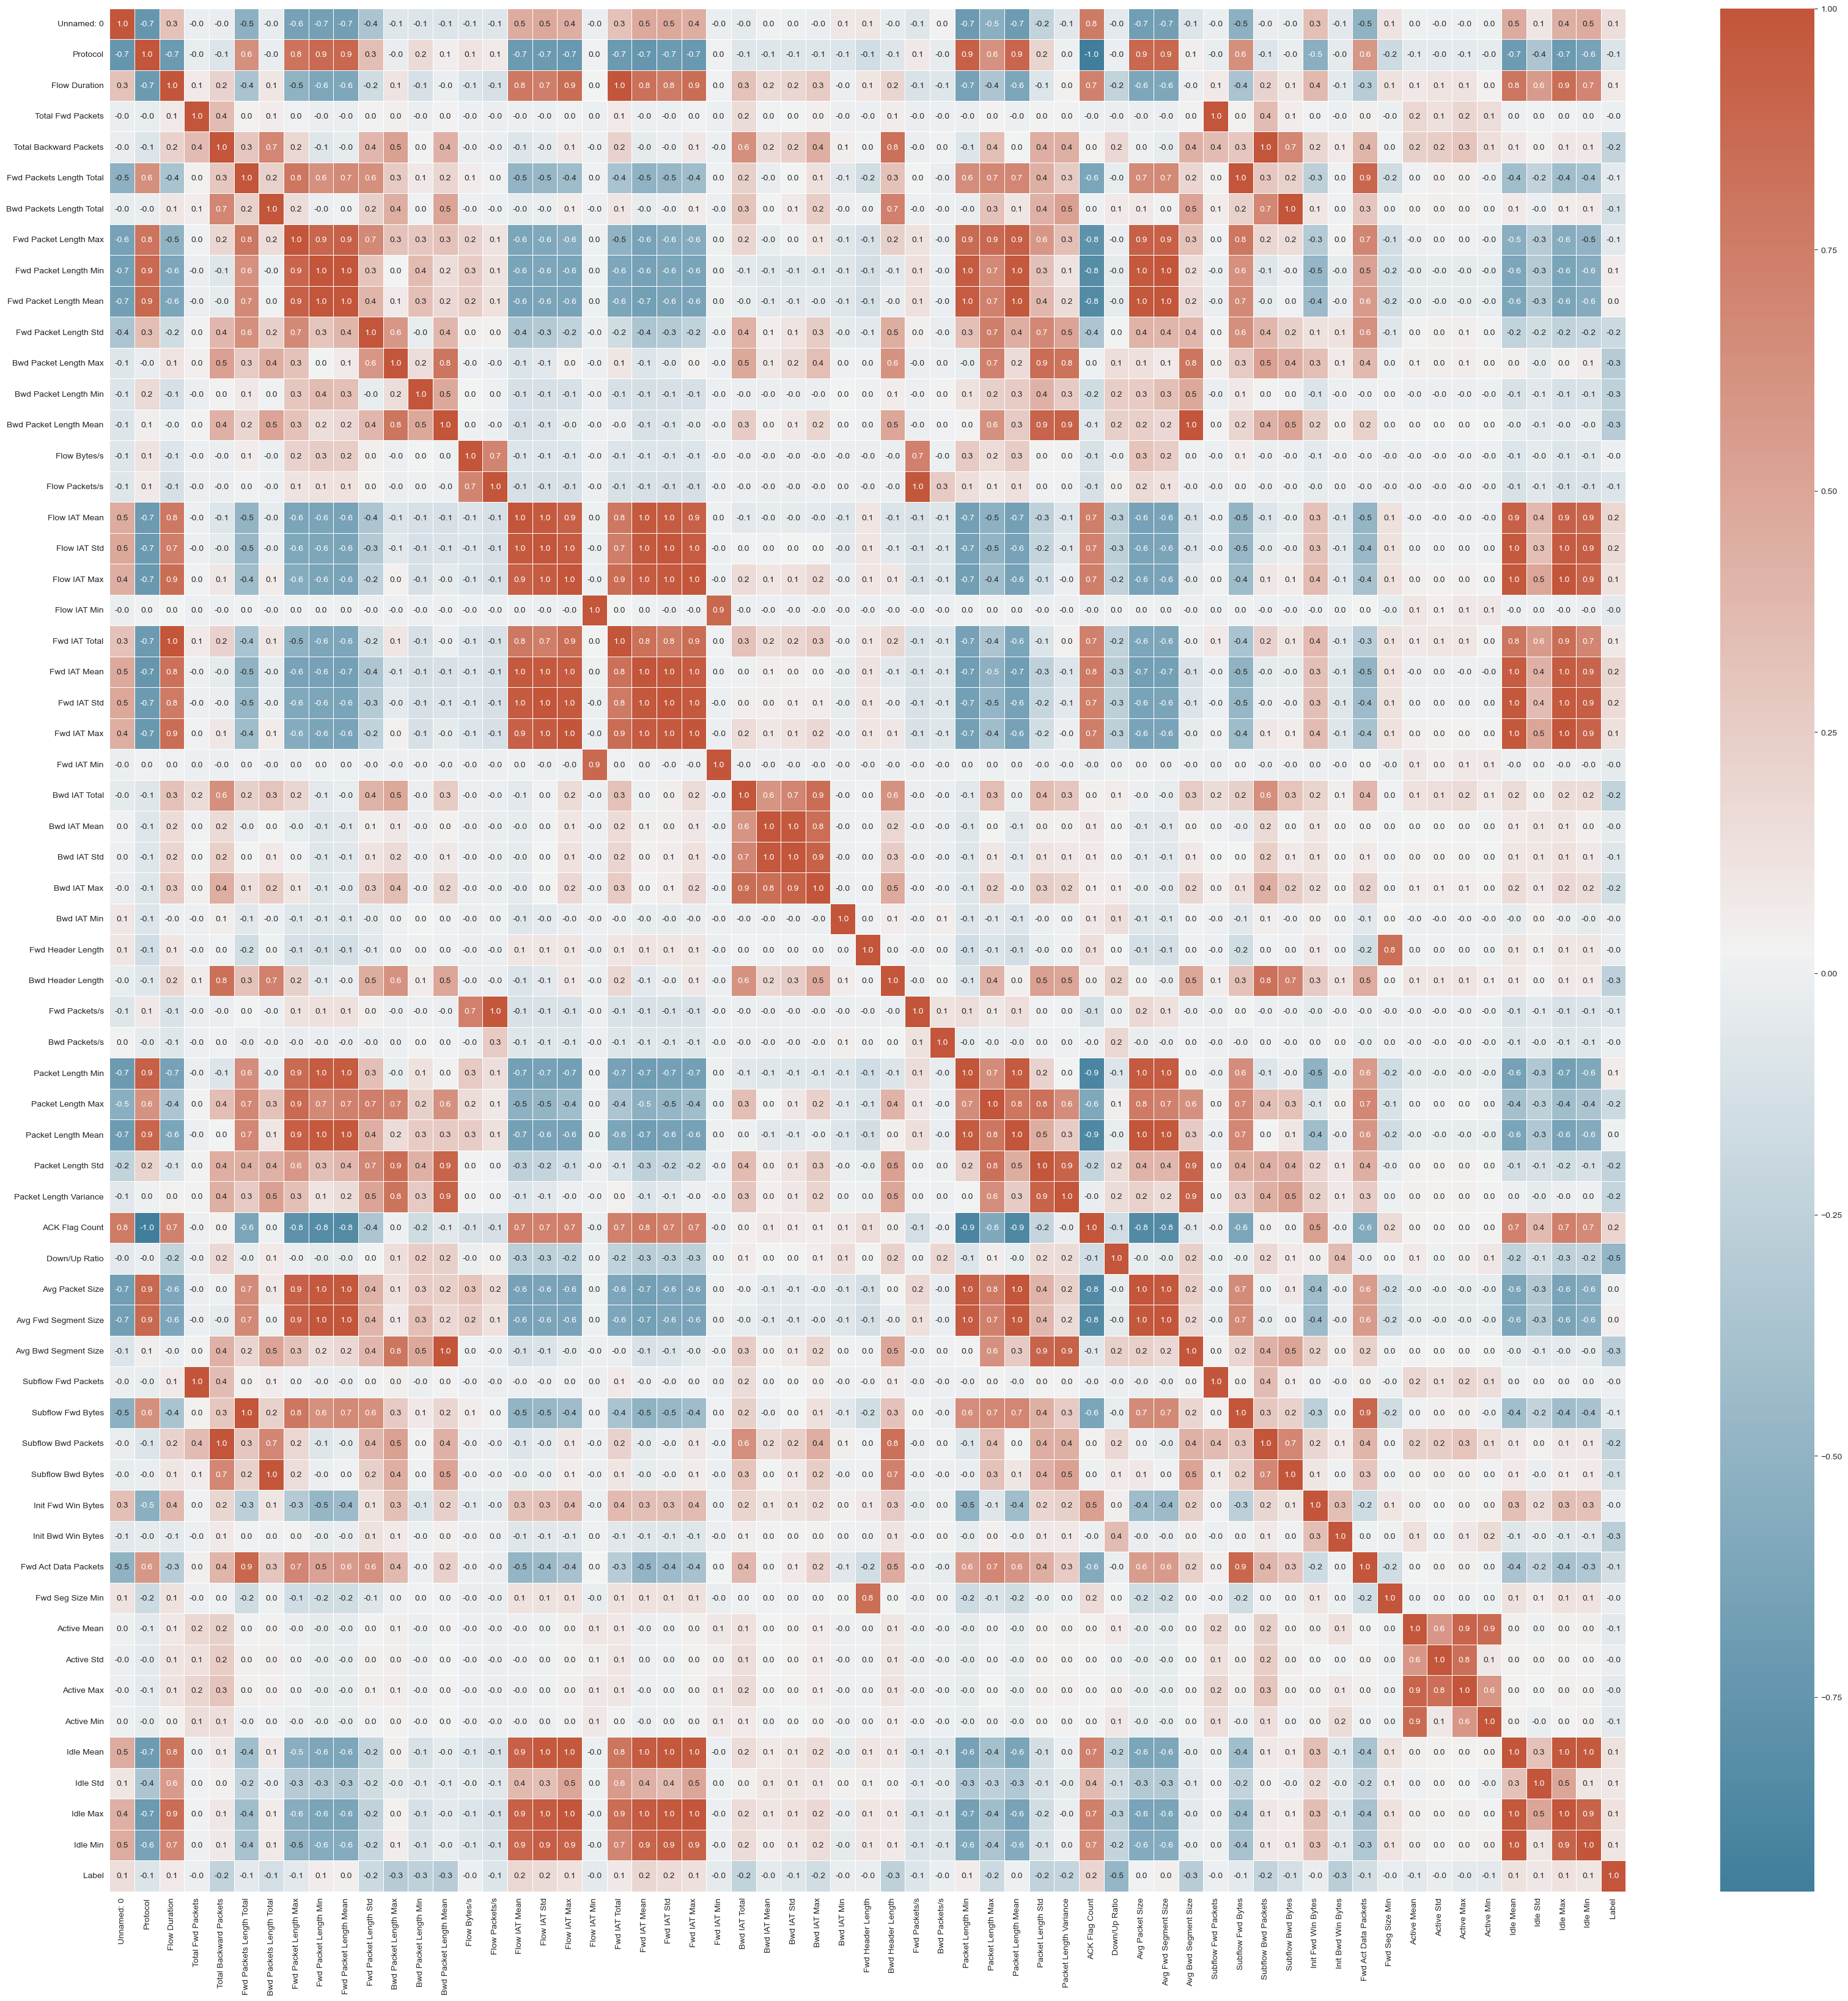

In [37]:
target_var_list = ['Label']  # excluding target variable
x = workingDataFrame.drop(target_var_list, axis=1)
#Correlation map
correlation_of_x= workingDataFrame.corr()
f, ax = plt.subplots(figsize=(40, 40))

# Configure a custom diverging colormap
cmap = sns.diverging_palette(230, 20, as_cmap=True)
# Generate a mask for upper traingle
mask = np.triu(np.ones_like(correlation_of_x, dtype=bool))
# Draw the heatmap
# sns.heatmap(data=correlation_of_x, annot=True, linewidths=.5, fmt='.1f', ax=ax)
# sns.heatmap(data=correlation_of_x, annot=True, linewidths=.5, fmt='.1f', ax=ax,cmap=cmap)
sns.heatmap(data=correlation_of_x, annot=True, linewidths=.5, fmt='.1f', ax=ax,cmap=cmap)

plt.savefig('images/heatMap_co-relation_matrix_before_feature_selection.png', dpi=300)

In [38]:
sns.heatmap(data=correlation_of_x, annot=True,mask = mask, linewidths=.5, fmt='.1f', ax=ax,cmap="RdYlGn")

plt.savefig('images/heatMap_upper_matrix_before_feature_selection.png', dpi=300)

<Figure size 640x480 with 0 Axes>

Univariate Selection to see features importance | Before heatmap

59


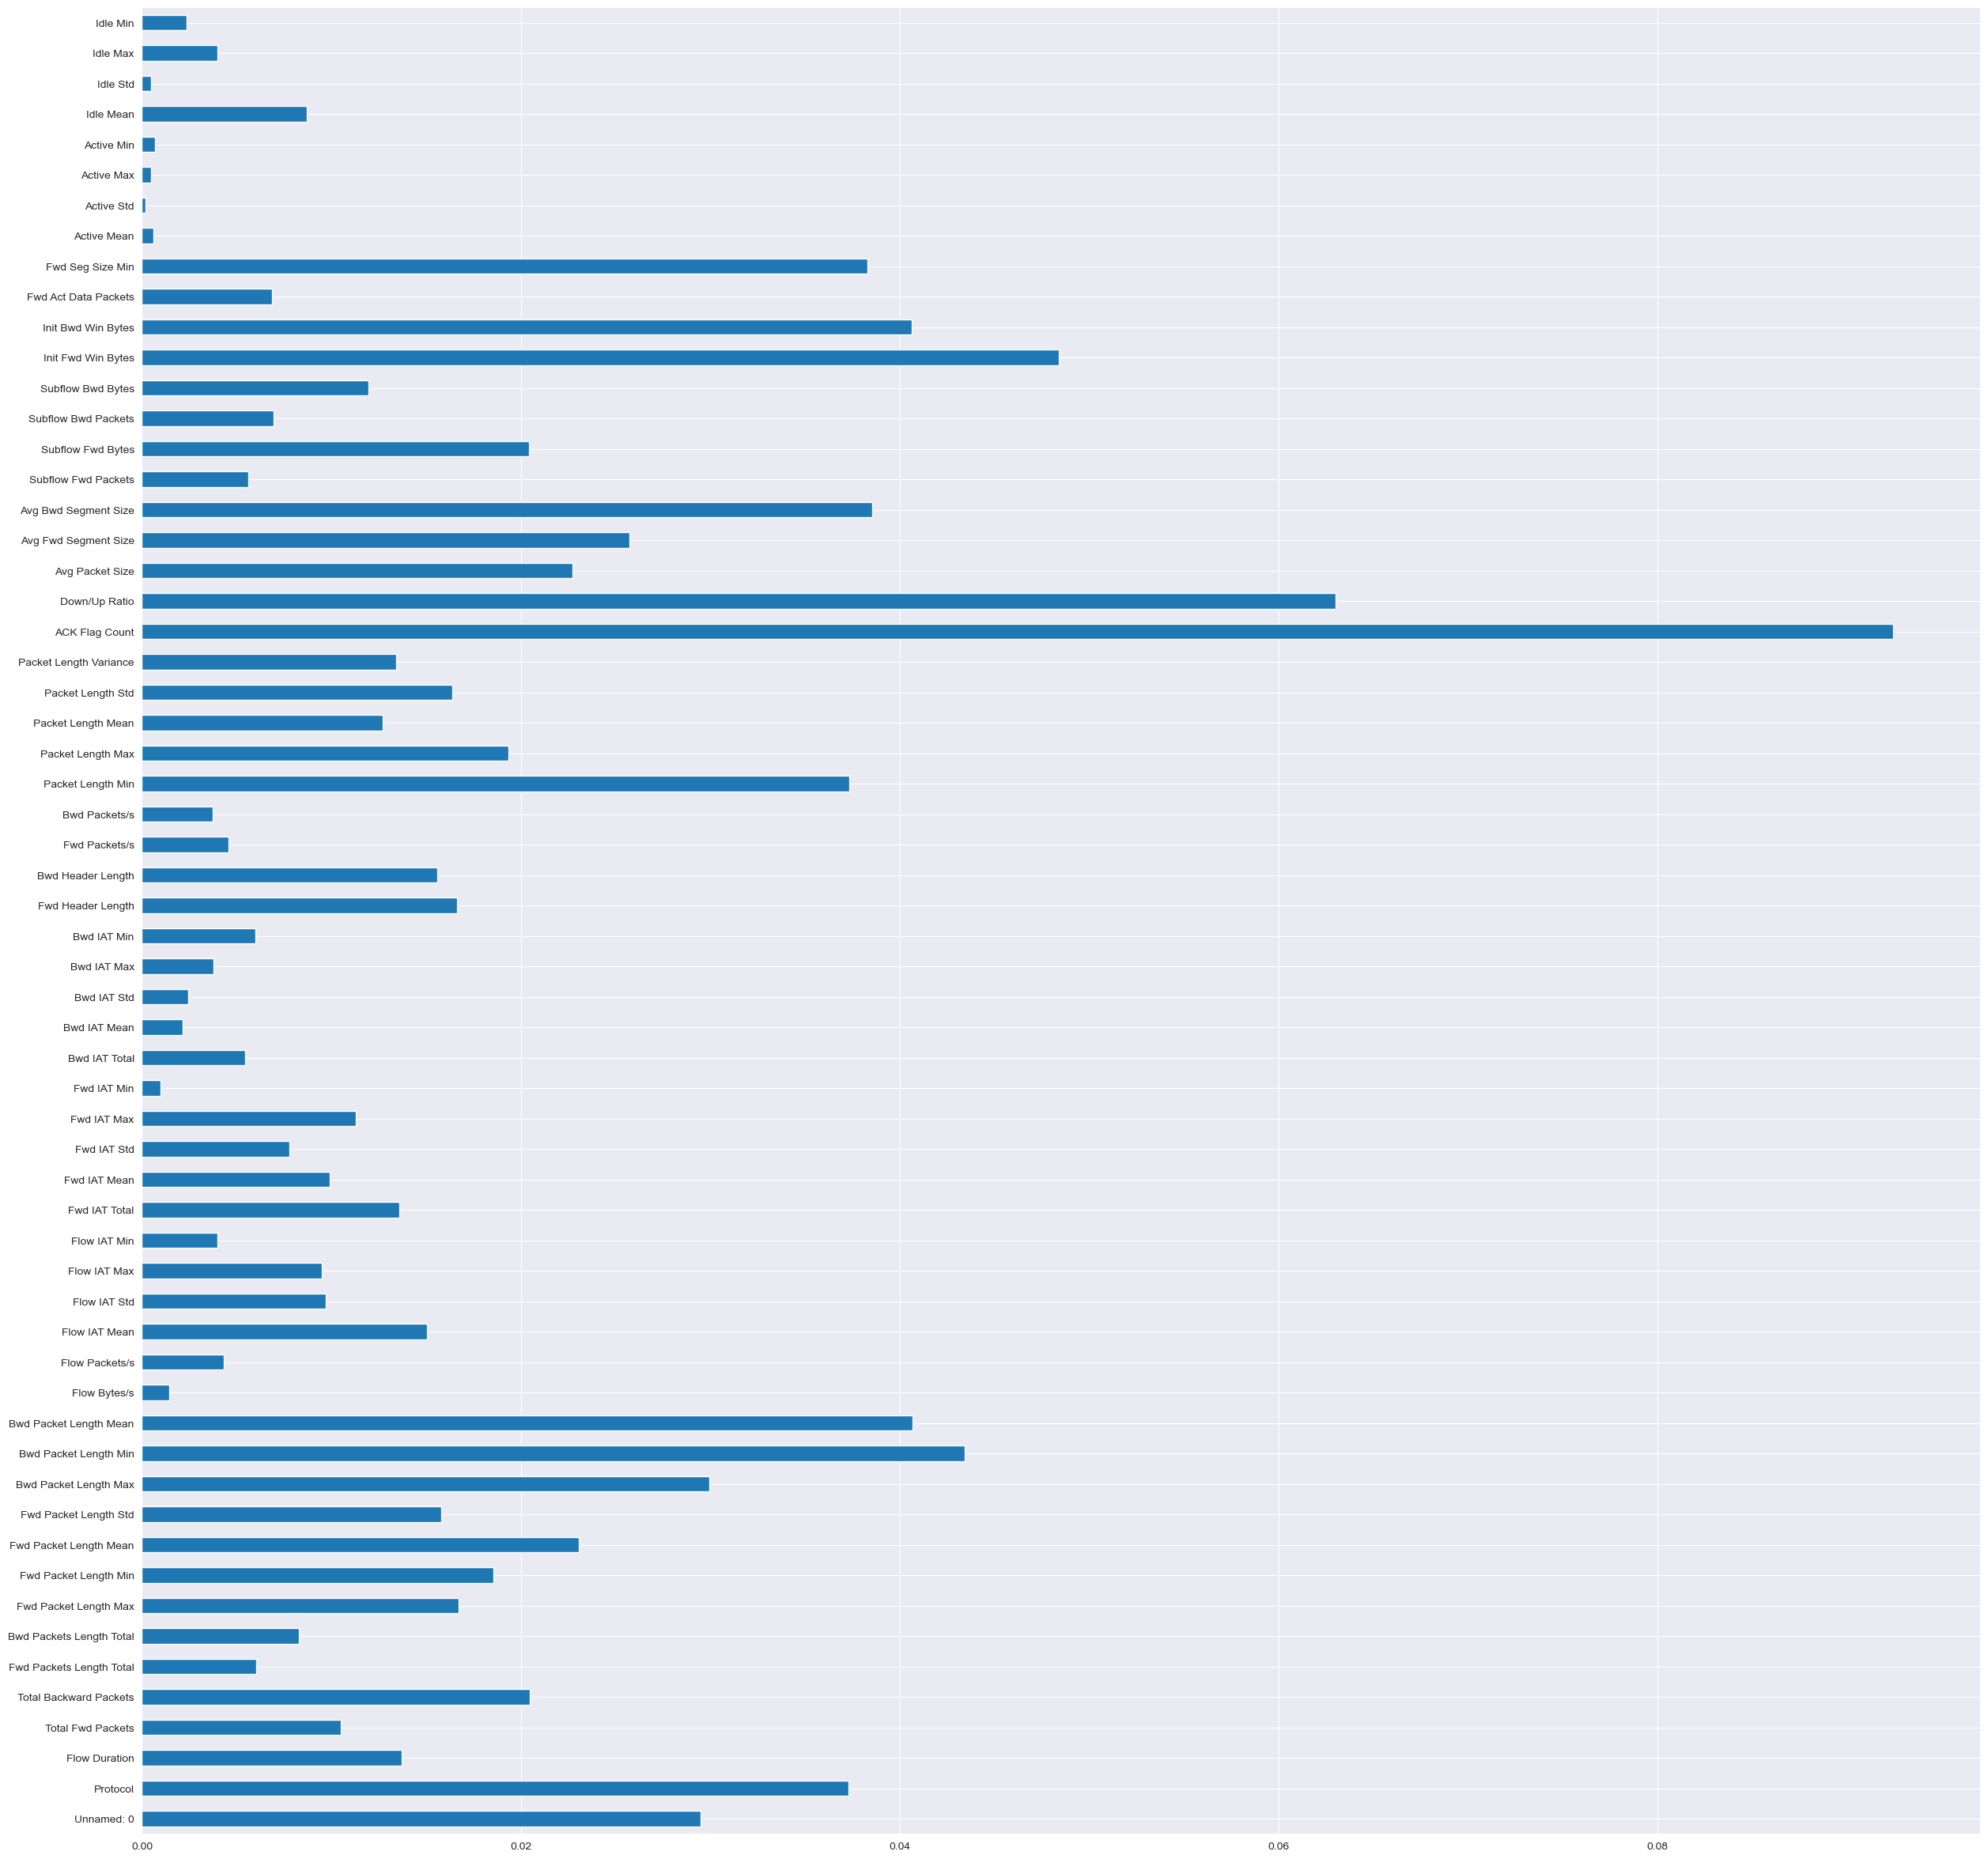

In [39]:
from sklearn.ensemble import ExtraTreesClassifier

target_variable_series = workingDataFrame.iloc[:,-1] # last feature is 'Label'
all_var_list = workingDataFrame.columns.to_list()
independent_variable_count = len(all_var_list)-1 # excluding target variable feature 'Label'
independent_variable_dataframe = workingDataFrame.iloc[:,0:independent_variable_count]

threshold_feature_importances = 0.08
model = ExtraTreesClassifier()
model.fit(independent_variable_dataframe,target_variable_series)
# print(model.feature_importances_) #use inbuilt class

less_imp_features01 = []
for i in model.feature_importances_:
    if i < threshold_feature_importances:
        less_imp_features01.append(i)

print(len(less_imp_features01))

#plot graph of feature importances for better visualization
feat_importances = pd.Series(model.feature_importances_, index=independent_variable_dataframe.columns)
# feat_importances.nlargest(threshold_value).plot(kind='barh')
# feature_to_show = feat_importances.nsmallest(threshold_value).plot(kind='barh')
feature_to_show = feat_importances.plot(kind='barh', figsize=(30,30))
plt.savefig('images/feature_importance_before_feature_selection.png',bbox_inches='tight',dpi=300)
plt.show()

Filter Method | Pearson Correlation

In [40]:
Fwd_Packet_Length_relation = ['Fwd Packets Length Total','Fwd Packet Length Max','Fwd Packet Length Min','Fwd Packet Length Mean']
workingDataFrame[Fwd_Packet_Length_relation].corr()

,Fwd Packets Length Total,Fwd Packet Length Max,Fwd Packet Length Min,Fwd Packet Length Mean
Fwd Packets Length Total,1.000000,0.787165,0.628063,0.678381
Fwd Packet Length Max,0.787165,1.000000,0.896896,0.931106
Fwd Packet Length Min,0.628063,0.896896,1.000000,0.994643
Fwd Packet Length Mean,0.678381,0.931106,0.994643,1.000000


In [41]:
Bwd_Packet_Length_relation = ['Bwd Packets Length Total','Bwd Packet Length Max','Bwd Packet Length Min','Bwd Packet Length Mean',]
workingDataFrame[Bwd_Packet_Length_relation].corr()

,Bwd Packets Length Total,Bwd Packet Length Max,Bwd Packet Length Min,Bwd Packet Length Mean
Bwd Packets Length Total,1.000000,0.445494,0.011874,0.509051
Bwd Packet Length Max,0.445494,1.000000,0.152334,0.797516
Bwd Packet Length Min,0.011874,0.152334,1.000000,0.487561
Bwd Packet Length Mean,0.509051,0.797516,0.487561,1.000000


In [42]:
Fwd_IAT_relations = ['Fwd IAT Total','Fwd IAT Mean','Fwd IAT Std','Fwd IAT Max']
workingDataFrame[Fwd_IAT_relations].corr()

,Fwd IAT Total,Fwd IAT Mean,Fwd IAT Std,Fwd IAT Max
Fwd IAT Total,1.000000,0.826328,0.760072,0.851241
Fwd IAT Mean,0.826328,1.000000,0.980524,0.961280
Fwd IAT Std,0.760072,0.980524,1.000000,0.971378
Fwd IAT Max,0.851241,0.961280,0.971378,1.000000


In [43]:
Bwd_IAT_relations = ['Bwd IAT Total','Bwd IAT Mean','Bwd IAT Std','Bwd IAT Max',]
workingDataFrame[Bwd_IAT_relations].corr()

,Bwd IAT Total,Bwd IAT Mean,Bwd IAT Std,Bwd IAT Max
Bwd IAT Total,1.000000,0.604500,0.697195,0.851576
Bwd IAT Mean,0.604500,1.000000,0.983099,0.844171
Bwd IAT Std,0.697195,0.983099,1.000000,0.922760
Bwd IAT Max,0.851576,0.844171,0.922760,1.000000


In [44]:
Flow_IAT_relations = ['Flow IAT Mean','Flow IAT Std','Flow IAT Max']
workingDataFrame[Flow_IAT_relations].corr()

,Flow IAT Mean,Flow IAT Std,Flow IAT Max
Flow IAT Mean,1.000000,0.976088,0.926176
Flow IAT Std,0.976088,1.000000,0.958850
Flow IAT Max,0.926176,0.958850,1.000000


In [45]:
Packet_length_relations = ['Packet Length Min','Packet Length Max','Packet Length Mean','Packet Length Std']
workingDataFrame[Packet_length_relations].corr()

,Packet Length Min,Packet Length Max,Packet Length Mean,Packet Length Std
Packet Length Min,1.000000,0.655984,0.963569,0.217484
Packet Length Max,0.655984,1.000000,0.787151,0.829330
Packet Length Mean,0.963569,0.787151,1.000000,0.451845
Packet Length Std,0.217484,0.829330,0.451845,1.000000


In [46]:

workingDataFrame[['Avg Packet Size','Avg Fwd Segment Size']].corr()

,Avg Packet Size,Avg Fwd Segment Size
Avg Packet Size,1.000000,0.981625
Avg Fwd Segment Size,0.981625,1.000000


In [47]:
Active_relations = ['Active Mean','Active Std','Active Max','Active Min']
workingDataFrame[Active_relations].corr()

,Active Mean,Active Std,Active Max,Active Min
Active Mean,1.000000,0.591716,0.905411,0.855493
Active Std,0.591716,1.000000,0.838050,0.092948
Active Max,0.905411,0.838050,1.000000,0.590896
Active Min,0.855493,0.092948,0.590896,1.000000


In [48]:
Idle_relations = ['Idle Mean','Idle Max','Idle Min']
workingDataFrame[Idle_relations].corr()

,Idle Mean,Idle Max,Idle Min
Idle Mean,1.000000,0.979663,0.974469
Idle Max,0.979663,1.000000,0.910659
Idle Min,0.974469,0.910659,1.000000


In [49]:
direct_from_heatmap = ['Flow IAT Max','Fwd IAT Min','Idle Max','Bwd IAT Min','Fwd Seg Size Min','Active Min']
drop_columns_from_heatmap = ['Idle Mean','Idle Max','Idle Min','Active Mean','Active Std','Active Min','Avg Packet Size','Flow IAT Mean','Flow IAT Std','Bwd IAT Max','Bwd IAT Mean','Bwd IAT Std','Fwd IAT Max','Fwd IAT Mean','Fwd IAT Std','Bwd Packet Length Max','Bwd Packet Length Min','Bwd Packets Length Total','Packet Length Min','Packet Length Mean','Packet Length Max','Packet Length Variance','Fwd Packets Length Total','Fwd Packet Length Max','Fwd Packet Length Min','Fwd Packet Length Mean','Flow IAT Max','Fwd IAT Min','Bwd IAT Min','Fwd Seg Size Min','Active Min']

workingDataFrame.drop(columns=drop_columns_from_heatmap, inplace=True, errors='ignore')
workingDataFrame

,Unnamed: 0,Protocol,Flow Duration,Total Fwd Packets,Total Backward Packets,Fwd Packet Length Std,Bwd Packet Length Mean,Flow Bytes/s,Flow Packets/s,Flow IAT Min,...,Subflow Fwd Packets,Subflow Fwd Bytes,Subflow Bwd Packets,Subflow Bwd Bytes,Init Fwd Win Bytes,Init Bwd Win Bytes,Fwd Act Data Packets,Active Max,Idle Std,Label
0,0,17,1,2,0,0.0,0.0,766000000.0,2.000000e+06,1.0,...,2,766,0,0,-1,-1,1,0.0,0.0,1.0
1,1,17,1,2,0,0.0,0.0,778000000.0,2.000000e+06,1.0,...,2,778,0,0,-1,-1,1,0.0,0.0,1.0
2,2,17,2,2,0,0.0,0.0,375000000.0,1.000000e+06,2.0,...,2,750,0,0,-1,-1,1,0.0,0.0,1.0
3,3,17,2,2,0,0.0,0.0,369000000.0,1.000000e+06,2.0,...,2,738,0,0,-1,-1,1,0.0,0.0,1.0
4,4,17,1,2,0,0.0,0.0,750000000.0,2.000000e+06,1.0,...,2,750,0,0,-1,-1,1,0.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
87,92931,6,175,2,0,0.0,0.0,0.0,1.142857e+04,175.0,...,2,0,0,0,5840,-1,0,0.0,0.0,1.0
88,92932,6,2951,1,1,0.0,0.0,0.0,6.777364e+02,2951.0,...,1,0,1,0,243,64,0,0.0,0.0,2.0
89,92933,6,95,1,2,0.0,0.0,0.0,3.157895e+04,1.0,...,1,0,2,0,64,243,0,0.0,0.0,2.0
90,92934,6,114,2,2,0.0,0.0,0.0,3.508772e+04,0.0,...,2,0,2,0,5840,0,0,0.0,0.0,1.0


After Dropping less important columns

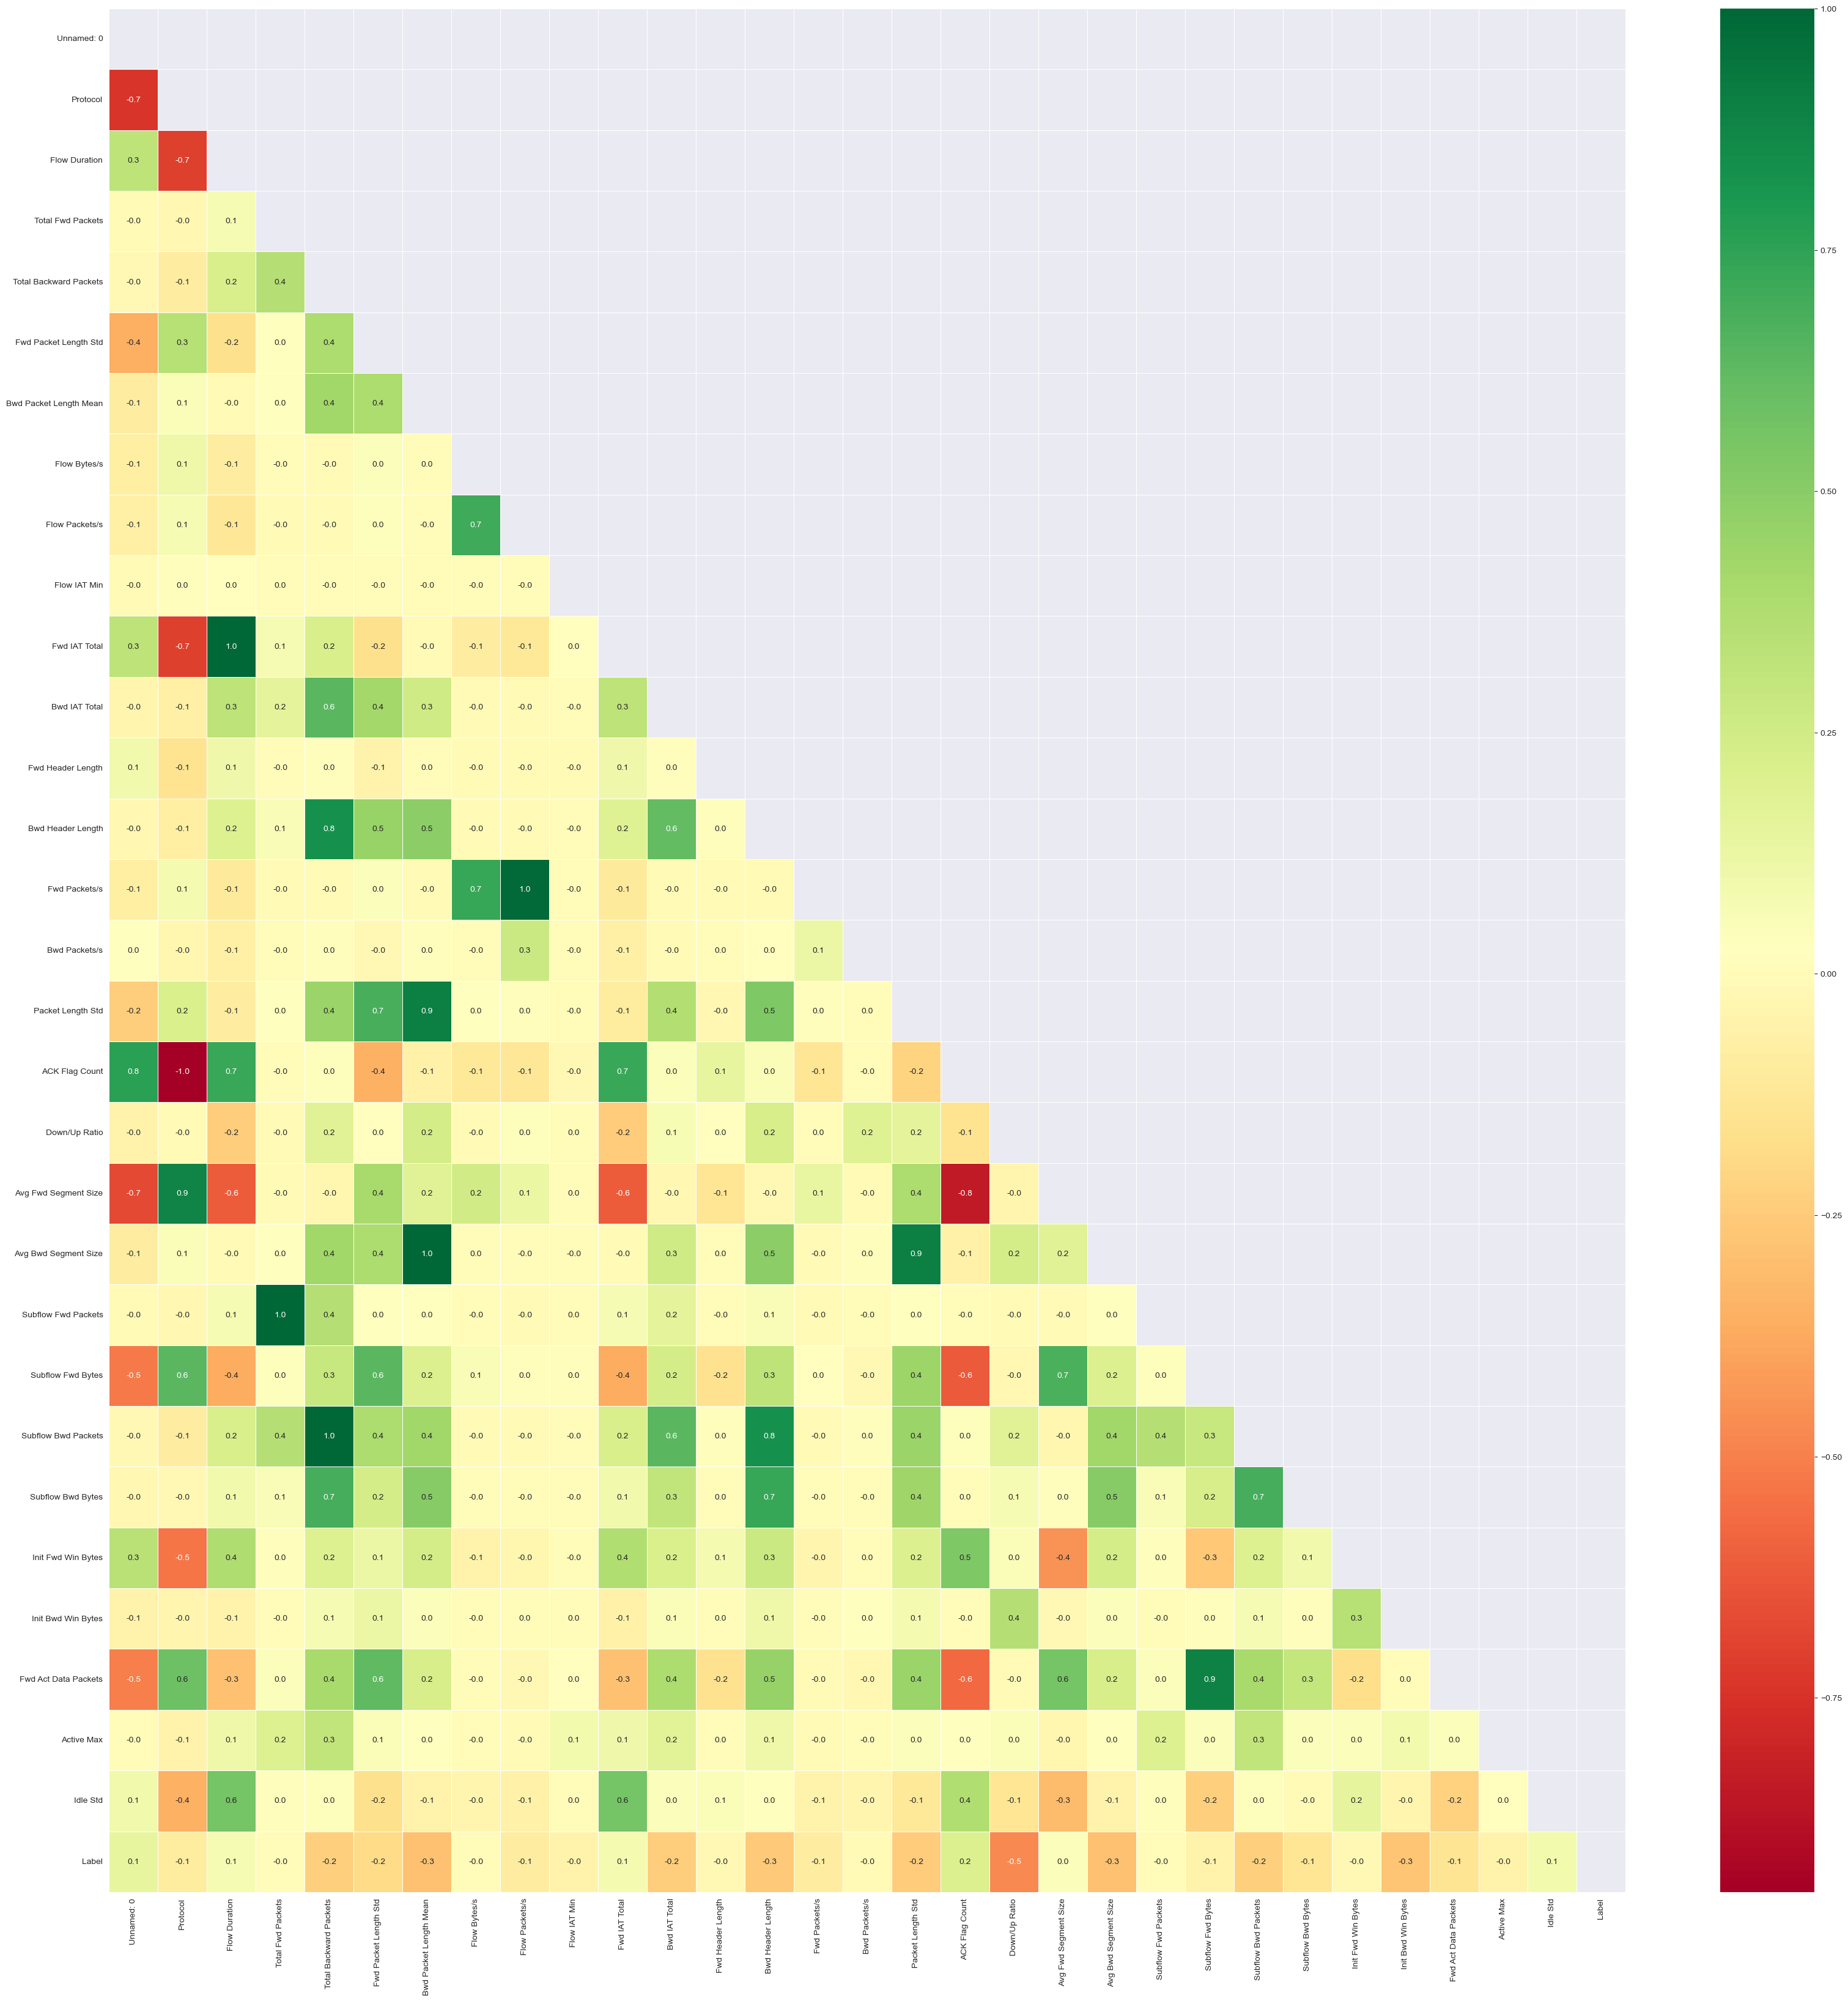

In [50]:
correlationMapAfterDropping= workingDataFrame.corr()
f, ax = plt.subplots(figsize=(40, 40))

# Configure a custom diverging colormap
cmap = sns.diverging_palette(230, 20, as_cmap=True)
# Generate a mask for upper traingle
mask = np.triu(np.ones_like(correlationMapAfterDropping, dtype=bool))
# Draw the heatmap
# sns.heatmap(data=correlationMapAfterDropping, annot=True, linewidths=.5, fmt='.1f', ax=ax)
# sns.heatmap(data=correlationMapAfterDropping, annot=True, mask = mask, linewidths=.5, fmt='.1f', ax=ax,cmap=cmap)
sns.heatmap(data=correlationMapAfterDropping, annot=True, mask = mask, linewidths=.5, fmt='.1f', ax=ax,cmap="RdYlGn")
plt.savefig('images/heatmap_after_pearson_co-relation.png', dpi=300)

In [51]:
pearson_threshold = 0.09
target_cor = abs(correlationMapAfterDropping['Label'])
above_threshold = target_cor[target_cor > pearson_threshold]
above_threshold

Unnamed: 0                0.140324
Protocol                  0.095489
Total Backward Packets    0.229283
Fwd Packet Length Std     0.182151
Bwd Packet Length Mean    0.290732
Bwd IAT Total             0.239068
Bwd Header Length         0.257294
Packet Length Std         0.246456
ACK Flag Count            0.204770
Down/Up Ratio             0.476042
Avg Bwd Segment Size      0.290732
Subflow Bwd Packets       0.229283
Subflow Bwd Bytes         0.131906
Init Bwd Win Bytes        0.276091
Fwd Act Data Packets      0.141202
Label                     1.000000
Name: Label, dtype: float64

Univariate Selection to see features importance | After heatmap

28


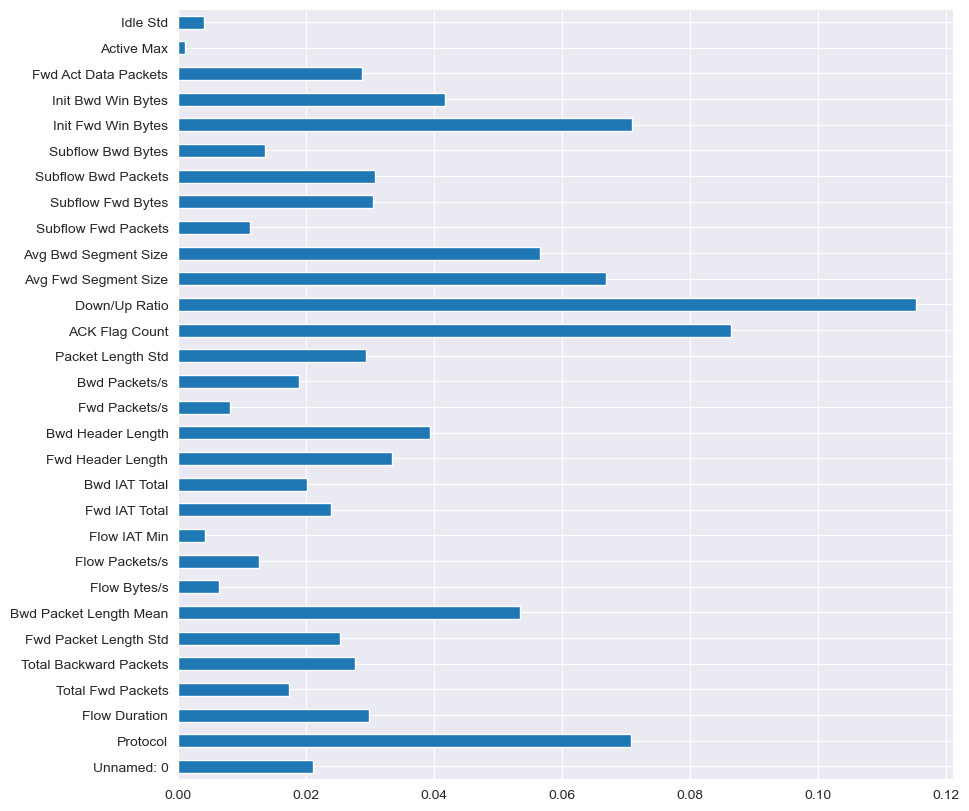

In [52]:
from sklearn.ensemble import ExtraTreesClassifier

target_variable_series = workingDataFrame.iloc[:,-1] # last feature is 'Label'
all_var_list = workingDataFrame.columns.to_list()
independent_variable_count = len(all_var_list)-1 # excluding target variable feature 'Label'
independent_variable_dataframe = workingDataFrame.iloc[:,0:independent_variable_count]

threshold_feature_importances = 0.08
model = ExtraTreesClassifier()
model.fit(independent_variable_dataframe,target_variable_series)
# print(model.feature_importances_) #use inbuilt class

less_imp_features = []
for i in model.feature_importances_:
    if i < threshold_feature_importances:
        less_imp_features.append(i)

print(len(less_imp_features))

#plot graph of feature importances for better visualization
feat_importances = pd.Series(model.feature_importances_, index=independent_variable_dataframe.columns)
# feat_importances.nlargest(threshold_value).plot(kind='barh')
# feature_to_show = feat_importances.nsmallest(threshold_value).plot(kind='barh')
feature_to_show = feat_importances.plot(kind='barh', figsize=(10,10))
plt.savefig('images/feature_importance_after_feature_selection.png',bbox_inches='tight',dpi=300)
# plt.savefig('images/feature_importance_after_feature_selection.png',bbox_inches='tight',dpi=300,transparent=True)
plt.show()